In [1]:
!pip install --quiet --upgrade comet_ml
from comet_ml import Experiment
    
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="0EKSrlH9OVngYfgQCrauwqLEt",
                        project_name="mri-interpretation", workspace="polina")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/polina/mri-interpretation/2b5c4f3a21814930928d2ad6ab47c9c6



In [2]:
# !pip install torchio

In [3]:
import numpy as np
import functools
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
# from torchsummary import summary
import os
import pathlib
from sklearn.model_selection import train_test_split, StratifiedKFold
import torchio
import nibabel as nib
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import *
import random
from sklearn.metrics import roc_auc_score, precision_score, recall_score
%matplotlib inline

In [4]:
import nilearn
from nilearn import plotting

In [5]:
from data import HCP_MRI_domain_scale
# from data import HCP_MRI_crop

In [6]:
 torch.cuda.is_available()

True

In [7]:
if torch.cuda.is_available():
  device = torch.device("cuda:5")
else:
  device = torch.device("cpu")

In [8]:
! nvidia-smi

Sun Apr 11 18:06:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:05:00.0 Off |                    0 |
| N/A   40C    P0    35W / 250W |  11915MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:08:00.0 Off |                    0 |
| N/A   29C    P0    33W / 250W |   1526MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

# Data

In [9]:
data_dir = pathlib.Path('/data/adni')

In [10]:
def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
# plot_central_cuts(nilearn.image.get_data(img)[np.newaxis,:], title="ex", t = None)
# plot_central_cuts(img_crop, title="ex", t = None)

In [11]:
# PATH_TO_MRI = '/data/hcp/HCP_T1_pm'
PATH_TO_MRI = '/home/scale_data'
data_dir = pathlib.Path('/data/adni')
behavioral_path = os.path.join('/data/adni', 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

In [12]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

HCP absmax before normalization: 435.0126647949219
Train Dataset size: 889
Test Dataset size: 223
Labels distribution: (array([0, 1]), array([482, 407]))

Train example:


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


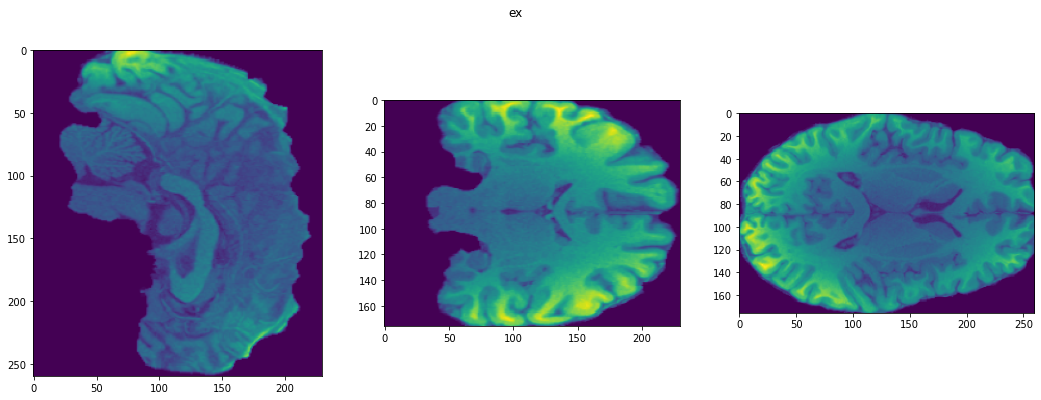

Val example:
Image shape: torch.Size([1, 176, 260, 230])
Type: <class 'torch.Tensor'>
Target: 1


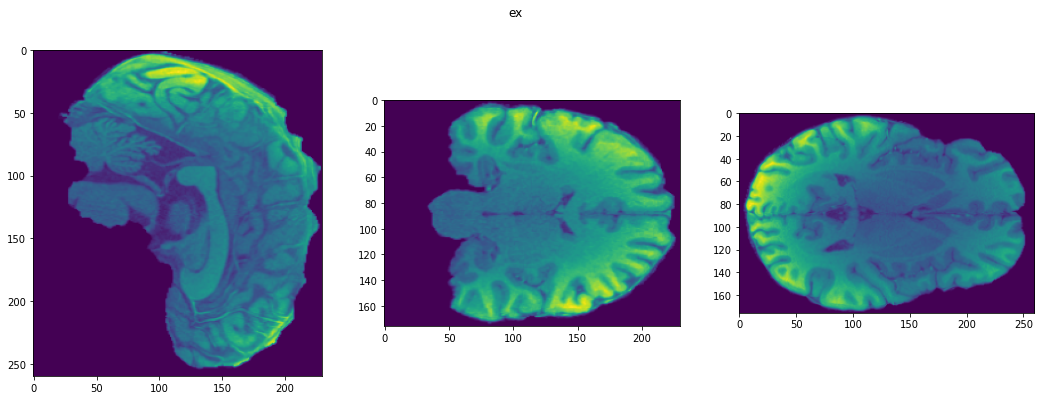

In [13]:
X_train, X_test = train_test_split(pd.read_csv(behavioral_path), test_size=0.2, random_state=42) 
train_hcp_dataset = HCP_MRI_domain_scale(
    paths= PATH_TO_MRI,
    target_path= X_train,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55,( 15, 15, 0, 19, 34, 51)
    img_shape=(176, 260, 230) #176, 260, 230, (226, 301, 235), 256, 320, 320
)
val_hcp_dataset = HCP_MRI_domain_scale(
    paths= PATH_TO_MRI,
    target_path= X_test,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40, 40, 30, 30, 45, 45), #40,25,55
    img_shape=(176, 260, 230) #176, 260, 230, 226, 301, 235), 256, 320, 320
)

hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
train_transform = Compose([
    ToTensor(),
#     BrightnessContrast(),
#     GaussNoise(),
    RandomRotation(degrees = 10),
    RandomAffine(degrees = 0, scale=(0.9, 1.1)) #0.8,1.2
#     ToTensor(),
])

val_transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
# train_transform = torchio.transforms.Compose([
# #     BrightnessContrast(),
# #     GaussNoise(),
#     torchio.transforms.RandomAffine(scales=(0.8, 1.2), degrees = 10),
# #     ToTensor(),
# ])

train_hcp_dataset.transform = train_transform
val_hcp_dataset.transform = val_transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Train Dataset size: {}".format(len(train_hcp_dataset)))
print("Test Dataset size: {}".format(len(val_hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(train_hcp_dataset.labels, return_counts=True)))

print("Train example:")
img, target = train_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)
print("Val example:")
img, target = val_hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [14]:
train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

# Model structure

In [14]:
# timing
from tqdm import tqdm

def get_metric(net, data_loader):
    net.eval()
    correct = 0
    true = []
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        true.append(pred.data.cpu().numpy())
        correct += pred.eq(target.data).cpu().sum()
        del data, target, out, pred
    accuracy = 100. * correct / len(data_loader.dataset)
    true = np.concatenate(true)
    roc_auc = roc_auc_score(data_loader.dataset.labels, true)
    pr = precision_score(data_loader.dataset.labels,  true)
    rec = recall_score(data_loader.dataset.labels, true)

    return accuracy.item(), roc_auc, pr, rec

def get_loss(net, data_loader):
    net.eval()
    loss = 0 
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device, dtype=torch.float)
        target = target.to(device)
    
        out = net(data)
        loss += criterion(out, target).item()*len(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        del data, target, out 
    accuracy = 100. * correct / len(data_loader.dataset)
    return loss / len(data_loader.dataset), accuracy.item()


def train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler=None, verbose=True, save=False, experiment= False):
    best_val_loss = 100000 #100_000
    best_val_acc = 0
    best_model = None
    train_loss_list = []
    val_loss_list = []
    train_acc_list = []
    val_acc_list = []
    loss, acc = get_loss(net, train_loader)
    train_loss_list.append(loss)
    train_acc_list.append(acc)
    loss, acc = get_loss(net, val_loader)
    val_loss_list.append(loss)
    val_acc_list.append(acc)
    del loss, acc
    if verbose:
        print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f}'.format(0, epochs, train_loss_list[-1], val_loss_list[-1]))

    net.to(device)
    for epoch in range(1, epochs+1):
        net.train()
        train_loss = 0
        train_correct = 0
        for X, y in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            X, y = X.to(device, dtype=torch.float), y.to(device)
            optimizer.zero_grad()
#             print(type(X))
            out = net(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(X)
            pred = out.data.max(1)[1] # get the index of the max log-probability
            train_correct += pred.eq(y.data).cpu().sum()
            del X, y, out, loss #freeing gpu space
        accuracy = 100. * train_correct / len(train_loader.dataset)
        train_loss_list.append(train_loss/len(train_loader.dataset))
        train_acc_list.append(accuracy.item())
            
        
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        loss, acc = get_loss(net, val_loader)
        val_loss_list.append(loss)
        val_acc_list.append(acc)
        
        if scheduler is not None:
            scheduler.step(val_acc_list[-1])

        if save and val_acc_list[-1] > best_val_acc:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_acc_model_' + model_name)    
            best_val_acc = val_acc_list[-1]
            
        if save and val_loss_list[-1] < best_val_loss:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + 'best_val_loss_model_' + model_name)
            best_val_loss = val_loss_list[-1]
            
        if save and epoch%5==0:
            torch.save(net.state_dict(), CHECKPOINTS_DIR + str(epoch) + '_epoch_model_' + model_name)
            
        freq = 1
        if verbose and epoch%freq==0:
            print('Epoch {:02d}/{} || Loss:  Train {:.4f} | Validation {:.4f} Acc: Train {:.4f} | Validation {:.4f}'.format(epoch, epochs, train_loss_list[-1], val_loss_list[-1], train_acc_list[-1], val_acc_list[-1] ))
        if experiment:
                experiment.log_metric("train_loss", train_loss_list[-1])
                experiment.log_metric("validate_loss", val_loss_list[-1])
                experiment.log_metric("train_acc", train_acc_list[-1])
                experiment.log_metric("validate_acc", val_acc_list[-1])
                experiment.log_epoch_end(epoch)
    return  max(train_acc_list),best_val_acc

In [17]:
torch.cuda.empty_cache()

In [ ]:
CHECKPOINTS_DIR =  '/home/checkpoints_torchio_reshape_golden_cv/'

In [15]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2,),
                
                nn.Conv3d(c, 2*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3, stride=2),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1896960, out_features=2), #4*c*5*7*5
        )
        self.gradients = None
        
     
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [19]:
if torch.cuda.device_count() > 1:
      d_ids= [2,3]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

model.to(device)

Let's use [2, 3] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [ ]:
# criterion = nn.NLLLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #return ADAM?
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=1)
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
criterion = nn.CrossEntropyLoss()


In [ ]:
model_name = '_checkpoints_torch_reshape_lr'
experiment.set_name("3DCNN_checkpoints_torch_reshape_lr")

In [ ]:
torch.manual_seed(1)
np.random.seed(1)
EPOCHS = 60

train_loss_list, val_loss_list, train_acc_list, val_acc_list = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 

In [ ]:
!cd /home/checkpoints_torchion_reshape && ls

In [ ]:
model.load_state_dict(torch.load('/home/checkpoints_torchion_reshape/best_acc_model__checkpoints_torchio_reshape'))
model.eval()

In [ ]:
get_metric(model, val_loader)

In [ ]:
get_metric(model, train_loader)

In [ ]:
!jupyter notebook list

In [16]:
# CHECKPOINTS_DIR =  '/home/checkpoints_domain_adapt_scale/'
CHECKPOINTS_DIR =  '/home/checkpoints_domain_adapt_scale_more_batch_size/'

In [17]:
def get_accuracy(net, data_loader):
    net.eval()
    correct = 0
    for data, target in tqdm(data_loader):
        data = data.to(device,dtype=torch.float)
        target = target.to(device)

        out = net(data)
        pred = out.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        del data, target
    accuracy = 100. * correct / len(data_loader.dataset)
    return accuracy.item()

In [18]:
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
cross_vall_acc_list = []
cross_vall_acc_list_train = []
j = 0
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
for X_train, X_test in skf.split(pd.read_csv(behavioral_path),pd.read_csv(behavioral_path).Gender):
    print('Doing {} split'.format(j))
    j += 1
    train_hcp_dataset = HCP_MRI_domain_scale(
    paths= PATH_TO_MRI,
    target_path= pd.read_csv(behavioral_path).iloc[X_train],
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(40,25,55),
    img_shape=(176, 260, 230)
    )
    val_hcp_dataset = HCP_MRI_domain_scale(
        paths= PATH_TO_MRI,
        target_path= pd.read_csv(behavioral_path).iloc[X_test],
        load_online=True,
        hcp_type = hcp_type,
        coord_min=(40, 40, 30, 30, 45, 45),
        img_shape=(176, 260, 230)
    )
    hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
    train_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    val_hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)
    train_transform = Compose([
        ToTensor(),
    #     BrightnessContrast(),
    #     GaussNoise(),
        RandomRotation(degrees = 10),
        RandomAffine(degrees = 0, scale=(0.9,1.1))
    #     ToTensor(),
    ])

    val_transform = Compose([
    #     BrightnessContrast(),
    #     GaussNoise(),
    #     Rotate(),
        ToTensor(),
    ])
    train_hcp_dataset.transform = train_transform
    val_hcp_dataset.transform = val_transform

    train_loader = torch_data.DataLoader(train_hcp_dataset,
                                          shuffle=True,
                                          batch_size=4)
    val_loader = torch_data.DataLoader(val_hcp_dataset,
                                    shuffle=False,
                                    batch_size=2)

#     model = mri_model.MriNet(C).to(device)
#     criterion = nn.NLLLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
#     scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15], gamma=0.1)
    c = 32
    model = MriNetGrad(c)
    if torch.cuda.device_count() > 1:
        d_ids= [5,3]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
    model_name = '_domain_adapt_scale_bs4{}'.format(j)
    experiment.set_name("3DCNN_domain_adapt_scale_bs4_cv_{}".format(j))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.3)
    criterion = nn.CrossEntropyLoss()
    EPOCHS = 30

    train_best_acc, val_best_acc = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, scheduler=scheduler, save=True, experiment= experiment) 
#     _, _, _, _ = train(EPOCHS, model, criterion, optimizer, train_loader, val_loader, device, scheduler=scheduler, save=False, verbose=False) 
    cross_vall_acc_list_train.append(train_best_acc) 
    cross_vall_acc_list.append(val_best_acc)
    print(cross_vall_acc_list[-1])
print("Train")
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list_train))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list_train, ddof=1))
print("Val")
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list, ddof=1))

Doing 0 split
Let's use [5, 3] GPUs!


  0%|          | 0/139 [00:00<?, ?it/s]/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
100%|██████████| 279/279 [03:30<00:00,  1.32it/s]


Epoch 00/30 || Loss:  Train 20.4899 | Validation 20.8099


100%|██████████| 279/279 [03:30<00:00,  1.33it/s]
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 01/30 || Loss:  Train 1.0651 | Validation 0.1514 Acc: Train 77.2973 | Validation 94.7935


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 02/30 || Loss:  Train 0.1435 | Validation 0.0969 Acc: Train 94.9550 | Validation 96.7684


100%|██████████| 279/279 [03:29<00:00,  1.33it/s]


Epoch 03/30 || Loss:  Train 0.0928 | Validation 0.0836 Acc: Train 96.5766 | Validation 97.6661


100%|██████████| 279/279 [03:30<00:00,  1.32it/s]


Epoch 04/30 || Loss:  Train 0.1161 | Validation 0.0880 Acc: Train 96.0360 | Validation 97.1275


100%|██████████| 279/279 [03:30<00:00,  1.33it/s]


Epoch 05/30 || Loss:  Train 0.1124 | Validation 0.0994 Acc: Train 95.4955 | Validation 96.9479


100%|██████████| 279/279 [03:41<00:00,  1.26it/s]


Epoch 06/30 || Loss:  Train 0.1048 | Validation 0.0742 Acc: Train 95.4955 | Validation 97.6661


100%|██████████| 279/279 [03:27<00:00,  1.34it/s]


Epoch 07/30 || Loss:  Train 0.0898 | Validation 0.0847 Acc: Train 96.0360 | Validation 96.9479


100%|██████████| 279/279 [03:27<00:00,  1.34it/s]


Epoch 08/30 || Loss:  Train 0.1020 | Validation 0.1125 Acc: Train 95.8559 | Validation 95.8707


100%|██████████| 279/279 [03:30<00:00,  1.33it/s]


Epoch 09/30 || Loss:  Train 0.0610 | Validation 0.0793 Acc: Train 98.3784 | Validation 97.1275


100%|██████████| 279/279 [03:26<00:00,  1.35it/s]


Epoch 10/30 || Loss:  Train 0.0635 | Validation 0.0954 Acc: Train 97.4775 | Validation 96.5889


100%|██████████| 279/279 [03:26<00:00,  1.35it/s]


Epoch 11/30 || Loss:  Train 0.0687 | Validation 0.1445 Acc: Train 98.0180 | Validation 94.6140


100%|██████████| 279/279 [03:28<00:00,  1.34it/s]


Epoch 12/30 || Loss:  Train 0.0474 | Validation 0.0660 Acc: Train 98.5586 | Validation 98.2047


100%|██████████| 279/279 [03:25<00:00,  1.36it/s]


Epoch 13/30 || Loss:  Train 0.0606 | Validation 0.0677 Acc: Train 98.1982 | Validation 97.8456


100%|██████████| 279/279 [03:30<00:00,  1.32it/s]


Epoch 14/30 || Loss:  Train 0.0562 | Validation 0.0682 Acc: Train 97.2973 | Validation 97.8456


100%|██████████| 279/279 [03:30<00:00,  1.33it/s]


Epoch 15/30 || Loss:  Train 0.0302 | Validation 0.0607 Acc: Train 99.6396 | Validation 97.6661


100%|██████████| 279/279 [03:29<00:00,  1.33it/s]


Epoch 16/30 || Loss:  Train 0.0383 | Validation 0.0619 Acc: Train 98.5586 | Validation 98.0251


100%|██████████| 279/279 [03:30<00:00,  1.32it/s]


Epoch 17/30 || Loss:  Train 0.0547 | Validation 0.0649 Acc: Train 97.8378 | Validation 98.2047


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 18/30 || Loss:  Train 0.0416 | Validation 0.0611 Acc: Train 98.0180 | Validation 98.0251


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 19/30 || Loss:  Train 0.0378 | Validation 0.0584 Acc: Train 98.1982 | Validation 98.3842


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 20/30 || Loss:  Train 0.0857 | Validation 0.0640 Acc: Train 97.1171 | Validation 97.6661


100%|██████████| 279/279 [03:29<00:00,  1.33it/s]


Epoch 21/30 || Loss:  Train 0.0190 | Validation 0.1039 Acc: Train 99.6396 | Validation 95.8707


100%|██████████| 279/279 [03:28<00:00,  1.34it/s]


Epoch 22/30 || Loss:  Train 0.0293 | Validation 0.0591 Acc: Train 99.0991 | Validation 97.8456


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 23/30 || Loss:  Train 0.0332 | Validation 0.0716 Acc: Train 98.9189 | Validation 97.4865


100%|██████████| 279/279 [03:30<00:00,  1.33it/s]


Epoch 24/30 || Loss:  Train 0.0379 | Validation 0.0839 Acc: Train 98.5586 | Validation 97.1275


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 25/30 || Loss:  Train 0.0203 | Validation 0.0578 Acc: Train 99.4595 | Validation 97.8456


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 26/30 || Loss:  Train 0.0335 | Validation 0.0621 Acc: Train 99.0991 | Validation 97.6661


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 27/30 || Loss:  Train 0.0408 | Validation 0.0551 Acc: Train 98.5586 | Validation 98.2047


100%|██████████| 279/279 [03:31<00:00,  1.32it/s]


Epoch 28/30 || Loss:  Train 0.0289 | Validation 0.0928 Acc: Train 99.2793 | Validation 96.4093


100%|██████████| 279/279 [03:30<00:00,  1.32it/s]


Epoch 29/30 || Loss:  Train 0.0166 | Validation 0.0551 Acc: Train 99.4595 | Validation 98.0251


100%|██████████| 279/279 [03:30<00:00,  1.33it/s]


Epoch 30/30 || Loss:  Train 0.0362 | Validation 0.0593 Acc: Train 98.7387 | Validation 97.6661
98.38420104980469
Doing 1 split


  0%|          | 0/140 [00:00<?, ?it/s]

Let's use [5, 3] GPUs!


100%|██████████| 278/278 [03:30<00:00,  1.32it/s]


Epoch 00/30 || Loss:  Train 4.8624 | Validation 4.4602


100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Epoch 01/30 || Loss:  Train 1.1758 | Validation 1.0861 Acc: Train 73.6086 | Validation 65.5856


100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Epoch 02/30 || Loss:  Train 0.1804 | Validation 0.0794 Acc: Train 94.0754 | Validation 97.6577


100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Epoch 03/30 || Loss:  Train 0.0980 | Validation 0.0686 Acc: Train 96.9479 | Validation 97.6577


100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Epoch 04/30 || Loss:  Train 0.1018 | Validation 0.0757 Acc: Train 95.8707 | Validation 96.7568


100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Epoch 05/30 || Loss:  Train 0.1150 | Validation 0.0775 Acc: Train 96.2298 | Validation 96.5766


100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Epoch 06/30 || Loss:  Train 0.0811 | Validation 0.0784 Acc: Train 97.6661 | Validation 97.6577


100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Epoch 07/30 || Loss:  Train 0.0863 | Validation 0.0571 Acc: Train 97.3070 | Validation 98.1982


100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Epoch 08/30 || Loss:  Train 0.0786 | Validation 0.0600 Acc: Train 97.3070 | Validation 97.8378


100%|██████████| 278/278 [03:26<00:00,  1.35it/s]


Epoch 09/30 || Loss:  Train 0.0870 | Validation 0.0632 Acc: Train 97.1275 | Validation 98.1982


100%|██████████| 278/278 [03:33<00:00,  1.30it/s]


Epoch 10/30 || Loss:  Train 0.0675 | Validation 0.0817 Acc: Train 97.3070 | Validation 97.4775


100%|██████████| 278/278 [03:33<00:00,  1.30it/s]


Epoch 11/30 || Loss:  Train 0.0722 | Validation 0.0575 Acc: Train 98.2047 | Validation 97.8378


100%|██████████| 278/278 [03:30<00:00,  1.32it/s]


Epoch 12/30 || Loss:  Train 0.0547 | Validation 0.0563 Acc: Train 98.2047 | Validation 98.1982


100%|██████████| 278/278 [03:32<00:00,  1.31it/s]


Epoch 13/30 || Loss:  Train 0.0565 | Validation 0.0619 Acc: Train 98.0251 | Validation 97.1171


100%|██████████| 278/278 [03:31<00:00,  1.31it/s]


Epoch 14/30 || Loss:  Train 0.0537 | Validation 0.0725 Acc: Train 98.2047 | Validation 96.2162


100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Epoch 15/30 || Loss:  Train 0.0673 | Validation 0.0699 Acc: Train 97.8456 | Validation 96.3964


100%|██████████| 278/278 [03:30<00:00,  1.32it/s]


Epoch 16/30 || Loss:  Train 0.0585 | Validation 0.0570 Acc: Train 98.3842 | Validation 98.1982


100%|██████████| 278/278 [03:26<00:00,  1.34it/s]


Epoch 17/30 || Loss:  Train 0.0509 | Validation 0.0551 Acc: Train 97.8456 | Validation 98.1982


100%|██████████| 278/278 [03:27<00:00,  1.34it/s]


Epoch 18/30 || Loss:  Train 0.0319 | Validation 0.0871 Acc: Train 99.1023 | Validation 96.0360


100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Epoch 19/30 || Loss:  Train 0.0461 | Validation 0.0562 Acc: Train 98.7433 | Validation 98.0180


100%|██████████| 278/278 [03:29<00:00,  1.33it/s]


Epoch 20/30 || Loss:  Train 0.0330 | Validation 0.0615 Acc: Train 99.1023 | Validation 97.1171


100%|██████████| 278/278 [03:33<00:00,  1.30it/s]


Epoch 21/30 || Loss:  Train 0.0602 | Validation 0.0600 Acc: Train 96.9479 | Validation 97.1171


100%|██████████| 278/278 [09:56<00:00,  2.15s/it] 


Epoch 22/30 || Loss:  Train 0.0386 | Validation 0.0552 Acc: Train 98.9228 | Validation 97.8378


100%|██████████| 278/278 [03:58<00:00,  1.16it/s]


Epoch 23/30 || Loss:  Train 0.0215 | Validation 0.0640 Acc: Train 99.4614 | Validation 96.7568


100%|██████████| 278/278 [03:34<00:00,  1.30it/s]


Epoch 24/30 || Loss:  Train 0.0227 | Validation 0.0590 Acc: Train 99.4614 | Validation 97.2973


100%|██████████| 278/278 [03:31<00:00,  1.31it/s]


Epoch 25/30 || Loss:  Train 0.0273 | Validation 0.0617 Acc: Train 99.1023 | Validation 98.3784


100%|██████████| 278/278 [03:32<00:00,  1.31it/s]


Epoch 26/30 || Loss:  Train 0.0274 | Validation 0.0848 Acc: Train 99.1023 | Validation 97.8378


100%|██████████| 278/278 [03:36<00:00,  1.28it/s]


Epoch 27/30 || Loss:  Train 0.0208 | Validation 0.0613 Acc: Train 99.6409 | Validation 98.1982


100%|██████████| 278/278 [03:34<00:00,  1.29it/s]


Epoch 28/30 || Loss:  Train 0.0342 | Validation 0.0546 Acc: Train 99.1023 | Validation 98.3784


100%|██████████| 278/278 [03:41<00:00,  1.26it/s]


Epoch 29/30 || Loss:  Train 0.0261 | Validation 0.0589 Acc: Train 99.1023 | Validation 98.3784


100%|██████████| 278/278 [03:31<00:00,  1.31it/s]


OSError: [Errno 28] No space left on device

In [ ]:
!jupyter notebook list

In [22]:
cross_vall_acc_list_train.append(float(99.6409))
cross_vall_acc_list_train.append(float(99.66))
cross_vall_acc_list_train

[99.63964080810547, 99.6409, 99.66]

In [23]:
cross_vall_acc_list.append(float(98.3784))
cross_vall_acc_list.append(float(98.54))
cross_vall_acc_list

[98.38420104980469, 98.3784, 98.54]

In [24]:
print("Train")
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list_train))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list_train))
print("Val")
print('Mean cross-validation accuracy (5-folds):', np.mean(cross_vall_acc_list))
print('Std cross-validation accuracy (5-folds):', np.std(cross_vall_acc_list))

Train
Mean cross-validation accuracy (5-folds): 99.64684693603515
Std cross-validation accuracy (5-folds): 0.009314816505768639
Val
Mean cross-validation accuracy (5-folds): 98.4342003499349
Std cross-validation accuracy (5-folds): 0.07484912606986446


In [33]:
model = MriNetGrad(c)
if torch.cuda.device_count() > 1:
        d_ids= [5,7]
        print("Let's use", d_ids, "GPUs!")
        # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
        model = nn.DataParallel(model, device_ids=d_ids)
        model.to(device)
model.load_state_dict(torch.load('/home/checkpoints_domain_adapt_scale/best_acc_model__domain_adapt_scale_3'))
model.eval()

Let's use [5, 7] GPUs!


DataParallel(
  (module): MriNetGrad(
    (features): Sequential(
      (0): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (5): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1))
      (9): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU()
    )
    (classifier): Sequential(
      (0): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Dropout(p=0.5, inplace=False)
      (3): Linear(in_feat

In [34]:
get_metric(model, val_loader)

100%|██████████| 278/278 [03:36<00:00,  1.28it/s]


(98.01802062988281, 0.9801848022406617, 0.9763779527559056, 0.9802371541501976)

In [25]:
check_rot = []
check_rot.append(float(89.29))
check_rot.append(float(93.69))
check_rot.append(float(91.89))
print('Mean cross-validation accuracy (5-folds):', np.mean(check_rot))
print('Std cross-validation accuracy (5-folds):', np.std(check_rot))

Mean cross-validation accuracy (5-folds): 91.62333333333333
Std cross-validation accuracy (5-folds): 1.8061622912192052
